In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
import yasa
from scipy import signal
import json
from params import *

In [2]:
subject = 'S10'

In [3]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [16]:
freq_sp = (11, 16) # Spindles frequency range. YASA uses a FIR filter (implemented in MNE) with a 1.5Hz transition band, which means that for freq_sp = (12, 15 Hz), the -6 dB points are located at 11.25 and 15.75 Hz.
sp_duration = (0.3, 2.5) # The minimum and maximum duration of the spindles. In secs
sp_min_distance = 500 # If two spindles are closer than min_distance (in ms), they are merged into a single spindles. in milliseconds

# 'rel_pow': Relative power (= power ratio freq_sp / freq_broad).
# 'corr': Moving correlation between original signal and sigma-filtered signal.
# 'rms': Number of standard deviations above the mean of a moving root mean square of sigma-filtered signal.
# sp_thresh = {'corr': 0.3, 'rel_pow': None, 'rms': 0.2} # default = 0.65 , 0.2 , 1.5 
# sp_thresh = {'corr': 0.65, 'rel_pow': 0.2, 'rms': 1.5} # default = 0.65 , 0.2 , 1.5 
sp_thresh = {'corr': None, 'rel_pow': None, 'rms': 1.5} # default = 0.65 , 0.2 , 1.5 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(4, 13)


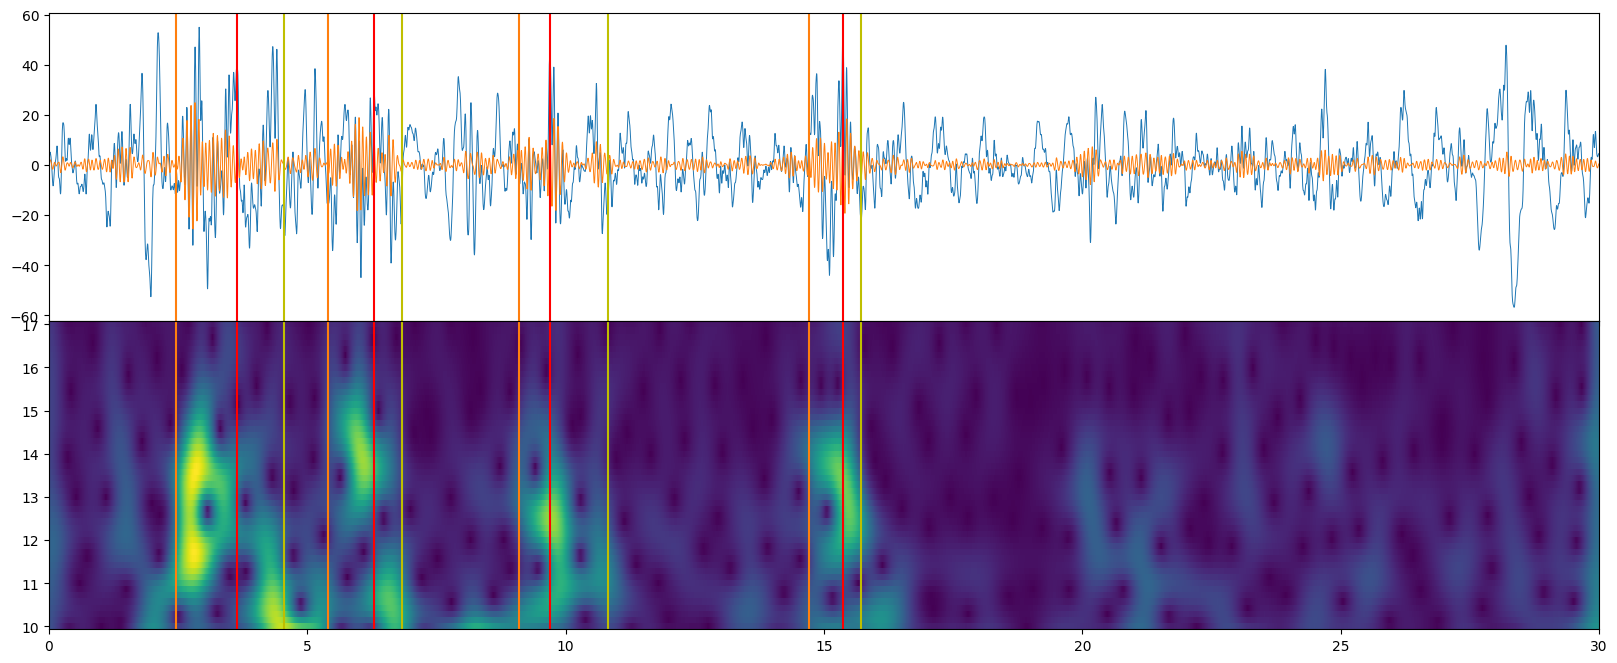

In [17]:
t_start = 13490
wsize = 30
start = t_start
stop = t_start + wsize

sig = data.loc['Fz',start:stop].values

sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = sp_thresh, verbose = 'error')
if not sp is None:
    sps = sp.summary()
else:
    sps = pd.DataFrame()
    
print(sps.shape)

sig_filt = gh.iirfilt(sig, srate, 1, 30, show= False, order = 10)
sigma = gh.iirfilt(sig, srate, freq_sp[0], freq_sp[1], show= False, order = 1)
t = gh.time_vector(sig, srate)

f, power = gh.morlet_power(sig, srate, 10, 17, 50, 20, amplitude_exponent = 1)

fig, axs = plt.subplots(nrows = 2, figsize = (20,8), sharex = True)
fig.subplots_adjust(hspace = 0)
# ax.plot(t, sig)
ax = axs[0]
ax.plot(t, sig_filt, lw = 0.7)
ax.plot(t, sigma, lw = 0.7)
ax.set_xlim(0, stop - start)

for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')
    
ax = axs[1]
ax.pcolormesh(t, f, power)
for i, row in sps.iterrows():
    ax.axvline(row['Start'], color = 'tab:orange')
    ax.axvline(row['Peak'], color = 'red')
    ax.axvline(row['End'], color = 'y')

In [6]:
corrs = [ 0.4 , 0.65 , 0.8]
Relpowers = [ 0.1 , 0.2 , 0.3]
rmss = [1, 1.5, 2]

sig = data.loc['Fz',:].values

rows = []
for corr_val in corrs:
    print(corr_val)
    for relpow_val in Relpowers:
        for rms_val in rmss:
            if corr_val is None and relpow_val is None and rms_val is None:
                continue
                
            test_thresh = {'corr':corr_val , 'rel_pow':relpow_val, 'rms':rms_val}
            sp = yasa.spindles_detect(sig, sf=srate, freq_sp = freq_sp, duration = sp_duration, min_distance = sp_min_distance, thresh = test_thresh, verbose = 'critical')
            if sp is None:
                N = 0
            else:
                N = sp.summary().shape[0]
                
            rows.append([corr_val, relpow_val, rms_val, N])
N_sp = pd.DataFrame(rows, columns = ['corr','rel_pow','rms', 'N'])        

0.4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.65


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

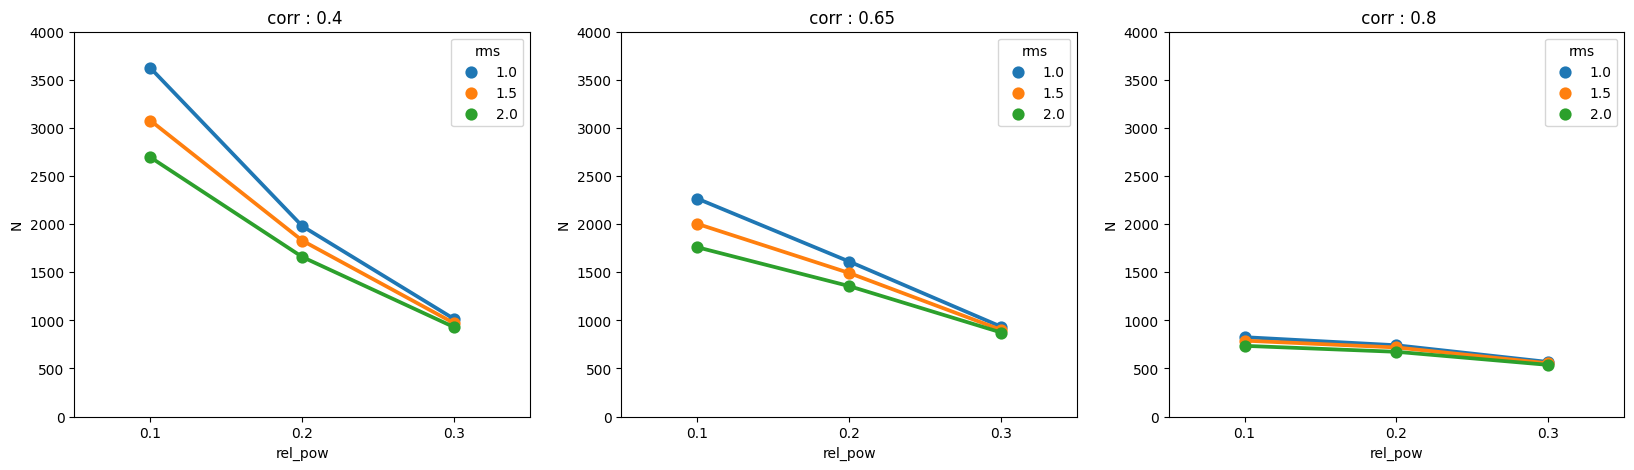

In [7]:
fig, axs = plt.subplots(ncols = N_sp['corr'].unique().size, figsize = (20,5))
for c, corr_val in enumerate(N_sp['corr'].unique()):
    ax = axs[c]
    if not corr_val > 0:    
        df_plot = N_sp[N_sp['corr'].isna()]
    else:
        df_plot = N_sp[N_sp['corr'] == corr_val]
    sns.pointplot(data = df_plot, x = 'rel_pow', y = 'N', hue = 'rms', ax=ax)
    ax.set_ylim(0,4000)
    ax.set_title(f' corr : {corr_val}')
    

In [8]:
# morlet_power = xr.open_dataarray('../sigma/S4_morlet_sigma_down.nc')